In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib
from scipy.stats.mstats import gmean
import scipy.optimize as opt
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
import numpy as np
from pathlib import Path
from skimage import io

In [3]:
sns.plotting_context("talk")

{'axes.linewidth': 1.875,
 'grid.linewidth': 1.5,
 'lines.linewidth': 2.25,
 'lines.markersize': 9.0,
 'patch.linewidth': 1.5,
 'xtick.major.width': 1.875,
 'ytick.major.width': 1.875,
 'xtick.minor.width': 1.5,
 'ytick.minor.width': 1.5,
 'xtick.major.size': 9.0,
 'ytick.major.size': 9.0,
 'xtick.minor.size': 6.0,
 'ytick.minor.size': 6.0,
 'font.size': 18.0,
 'axes.labelsize': 18.0,
 'axes.titlesize': 18.0,
 'xtick.labelsize': 16.5,
 'ytick.labelsize': 16.5,
 'legend.fontsize': 16.5,
 'legend.title_fontsize': 18.0}

In [4]:
sns.plotting_context("notebook")

{'axes.linewidth': 1.25,
 'grid.linewidth': 1,
 'lines.linewidth': 1.5,
 'lines.markersize': 6,
 'patch.linewidth': 1,
 'xtick.major.width': 1.25,
 'ytick.major.width': 1.25,
 'xtick.minor.width': 1,
 'ytick.minor.width': 1,
 'xtick.major.size': 6,
 'ytick.major.size': 6,
 'xtick.minor.size': 4,
 'ytick.minor.size': 4,
 'font.size': 12,
 'axes.labelsize': 12,
 'axes.titlesize': 12,
 'xtick.labelsize': 11,
 'ytick.labelsize': 11,
 'legend.fontsize': 11,
 'legend.title_fontsize': 12}

In [5]:
sns.plotting_context("paper")

{'axes.linewidth': 1.0,
 'grid.linewidth': 0.8,
 'lines.linewidth': 1.2000000000000002,
 'lines.markersize': 4.800000000000001,
 'patch.linewidth': 0.8,
 'xtick.major.width': 1.0,
 'ytick.major.width': 1.0,
 'xtick.minor.width': 0.8,
 'ytick.minor.width': 0.8,
 'xtick.major.size': 4.800000000000001,
 'ytick.major.size': 4.800000000000001,
 'xtick.minor.size': 3.2,
 'ytick.minor.size': 3.2,
 'font.size': 9.600000000000001,
 'axes.labelsize': 9.600000000000001,
 'axes.titlesize': 9.600000000000001,
 'xtick.labelsize': 8.8,
 'ytick.labelsize': 8.8,
 'legend.fontsize': 8.8,
 'legend.title_fontsize': 9.600000000000001}

In [6]:
p = Path('D:/qs-analysis/compiled-data/se')
p2 = Path('D:/qs-analysis/compiled-data/Figure 2')
if not (p2 / 'Data.pkl').exists() and not (p2 / 'mfi.pkl').exists():
    files = list(p.glob('**/*.pkl'))
    df = pd.DataFrame(columns=['FITC-A','AHL','IPTG','Family','Replicate'])
    for f in files:
        family = str(f.parent).split('\\')[-1]
        tmp = pd.read_pickle(f)
        df = df.append(tmp,ignore_index=True)
else:
    Data = pd.read_pickle(p2 / 'Data.pkl')
    mfi = pd.read_pickle(p2 / 'mfi.pkl')


In [7]:
def colorFader(c1,c2,n): #fade (linear interpolate) from color c1 (at mix=0) to c2 (mix=1)
    mix = np.linspace(0,1,n+1)
    c1=np.array(mpl.colors.to_rgb(c1))
    c2=np.array(mpl.colors.to_rgb(c2))
    cols = list()
    for i in range(n):
        cols.append(mpl.colors.to_hex((1-mix[i])*c1 + mix[i]*c2))
    return cols

def AHL_cmap(Family,n,r=False):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        if not r:
            Lux_rgbs = colorFader(c1,c2,n)
        else:
            Lux_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Lux_rgbs, name='LuxR')
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        if not r:
            Las_rgbs = colorFader(c1,c2,n)
        else:
            Las_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Las_rgbs, name='LasR')
    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        if not r:
            Tra_rgbs = colorFader(c1,c2,n)
        else:
            Tra_rgbs = colorFader(c2,c1,n)
        return matplotlib.colors.ListedColormap(Tra_rgbs, name='TraR')
def AHL_cols(Family,n):
    if Family == 'LuxR':
        c2='#ffffff' #white
        c1='#003f5c' #blue
        return colorFader(c1,c2,n)
    elif Family == 'LasR':
        c2='#ffffff' #white
        c1='#dd1c77' #pink #
        return colorFader(c1,c2,n)

    elif Family == 'TraR':
        c2='#ffffff' #white
        c1='#644895' #purple #
        return colorFader(c1,c2,n)
from typing import Optional


def restore_minor_ticks_log_plot(
    ax: Optional[plt.Axes] = None, n_subticks=9
) -> None:
    """For axes with a logrithmic scale where the span (max-min) exceeds
    10 orders of magnitude, matplotlib will not set logarithmic minor ticks.
    If you don't like this, call this function to restore minor ticks.

    Args:
        ax:
        n_subticks: Number of Should be either 4 or 9.

    Returns:
        None
    """
    if ax is None:
        ax = plt.gca()
    # Method from SO user importanceofbeingernest at
    # https://stackoverflow.com/a/44079725/5972175
    locmaj = mpl.ticker.LogLocator(base=10, numticks=1000)
    ax.xaxis.set_major_locator(locmaj)
    locmin = mpl.ticker.LogLocator(
        base=10.0, subs=np.linspace(0, 1.0, n_subticks + 2)[1:-1], numticks=1000
    )
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(mpl.ticker.NullFormatter())

In [8]:
def clean_df(df):
    data = df
    data['FITC-A'] = data['FITC-A'] - data[data.Family=='WT']['FITC-A'].median()
    data = data[data.Family != 'WT']

    data.IPTG = (data.IPTG * 1e3)
    data.IPTG = data.IPTG.astype('int16')

    gb = data.groupby(['AHL','IPTG','Family'])
    
    lg = gb.AHL.transform(np.log10).sort_values()
    lg[lg == -np.inf] = 0
    lg = lg.astype('int32')
    lg.name = 'logAHL'
    return pd.concat([data,lg],axis=1)


if not (p2 / 'Data.pkl').exists() and not (p2 / 'mfi.pkl').exists():
    Data = clean_df(df)
    mfi = Data.groupby(['IPTG','Family','logAHL','Replicate']).median().reset_index()
    mfi['R'] = mfi.groupby(['Family','IPTG','Replicate'])['FITC-A'].transform(lambda x: x.max()/x.min())
    Data.to_pickle(p2 / 'Data.pkl')
    mfi.to_pickle(p2 / 'mfi.pkl')

In [9]:
def make_heatmap(median_fluorescence,Family,ax=None, **kwargs):
    """
    This is a function to generate heatmaps
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    sns.set_style('white')
    # sns.set_context('paper')
    ax = ax or plt.gca()
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    # normalized
    norm = mfi[mfi.logAHL != 0].copy()
    norm['FITC-A']=norm['FITC-A']/norm.groupby(['AHL','IPTG']).mean().max()['FITC-A']*100

    piv = norm.pivot_table(index='IPTG', columns='logAHL', values='FITC-A')
    g = sns.heatmap(piv, vmin=0,ax=ax,square=True,**kwargs)
    cbar = g.collections[0].colorbar
    cbar.set_ticks([0, 25, 50, 75,100])
    cbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    cbar.ax.set_ylabel('Relative Expression Level')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'IPTG ($\mu M$)')
    spines = ["top","right","left","bottom"]
    for s in spines:
        ax.spines[s].set_visible(False)
        cbar.ax.spines[s].set_visible(False)
    #f.tight_layout()
    return 

In [10]:
def get_hill_params(median_fluorescence):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
            DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        Family (str)
            Name of AHL family to fit

    """
    fit = list()
    for Family in ['LuxR','LasR','TraR']:
        mfi = median_fluorescence[median_fluorescence.Family ==Family]
        fits = pd.DataFrame(columns=['Slope','EC50','Min','Max','IPTG','Family'])
        #data = Data[Data.Family =='LuxR']
        #cmap = matplotlib.cm.get_cmap(colormap)
        #colors = cmap(np.linspace(0,1,len(IPTG_range)+1))
        for replicate in mfi.Replicate.unique():
            for iptg in mfi.IPTG.unique():
                median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate)]
                max_ = median['FITC-A'].max()
                min_ = median['FITC-A'].min()
                median = mfi[(mfi.IPTG==iptg) & (mfi.Replicate == replicate) & (mfi.logAHL != 0)]
                #print(replicate,iptg)
                def func(x, a, b):
                    return (max_  - min_) / (1 + 10**(a * (np.log10(b)-np.log10(x)))) + min_
                (a_, b_), _ = opt.curve_fit(func, median.AHL, median['FITC-A'],p0=[1,1e-9],maxfev=10000000)
                fits=fits.append(pd.DataFrame([[a_,b_,min_,max_,iptg,Family]],columns=['Slope','EC50','Min','Max','IPTG','Family']),ignore_index=True)
        fit.append(fits)
    
    return pd.concat(fit,ignore_index=True)

In [11]:
def plot_hill(median_fluorescence,IPTG_range,Family,fits,colormap,ax=None,  **kwargs):
    """
    This is a function to generate Hill plots
    
    Args:
        median_fluorescence (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry median fluorescence intensity (mfi)
        
        standard_deviation (pd.DataFrame)
        DataFrame of filtered single family Lux/Las/Tra flow cytometry standard deviation of fluorescence intensity (mfi)
        
        IPTG_range (list)
        List of IPTG values to plot
        
        colormap (str)
        Name of colormap to use
        
        ax (plt.ax)
        Axis to plot data on
        
        **kwargs
        Addition arguments to pass to sns.heatmap
    """
    ax = ax or plt.gca()
    lines = []  
    n = len(IPTG_range)
    colors = AHL_cols(Family,n)
    mfi = median_fluorescence[median_fluorescence.Family ==Family]
    mean = mfi.groupby(['IPTG','logAHL']).mean().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    std = mfi.groupby(['IPTG','logAHL']).std().reset_index()[['IPTG','logAHL','AHL','FITC-A']]
    for i,iptg in enumerate(IPTG_range):
        mn = mean[(mean.IPTG==iptg) & (mean.logAHL != 0)]
        sd = std[(std.IPTG==iptg) & (std.logAHL != 0)]
        fit = fits[(fits.IPTG==iptg) & (fits.Family==Family)].mean()
        ax.errorbar(x=mn.logAHL.values,y=mn['FITC-A'].values,yerr=sd['FITC-A'].values,color=colors[i],capsize=5,ls='',marker='o')
        def func(x, slope, ec50,min_,max_):
            return (max_ -min_) / (1 + 10**(slope * (np.log10(ec50)-np.log10(x)))) + min_
        
        n = 1e6
        x = np.linspace(mn.AHL.min(), mn.AHL.max(), int(n))
        y_fit = func(x, fit['Slope'], fit['EC50'],fit['Min'],fit['Max'])
        # fits=fits.append(pd.DataFrame(np.concatenate([[x], [y_fit],[np.ones(len(x))*iptg]]).T,columns=['AHL','FITC-A','IPTG']),ignore_index=True)
        lines2, =ax.plot(np.log10(x), y_fit, '-',color = colors[i],label='IPTG {:.1f} fit'.format(iptg))
        lines += ax.plot(mn.logAHL.values, mn['FITC-A'].values, 'o',color = colors[i],label=r'IPTG {} $\mu M$'.format(iptg))

    labels = ['0','5','500']#[l.get_label() for l in lines]
    #labels = ax.get_labels()
    ax.legend(handles=lines,labels=labels,frameon=False,loc='upper left',title=r'IPTG ($\mu M$)')
    ax.set_xlabel(r'AHL ($10^x$ M)')
    ax.set_ylabel(r'mNG Intensity (au)')
    sns.despine()
    return 

In [12]:
median_fluorescence = mfi[mfi.Family=='LuxR']

In [13]:
def plot_hill_params(mfi,Family,fits,grid,**kwargs):

    gs1 = grid.subgridspec(3, 1)
    axes=gs1.subplots()
    median_fluorescence = mfi[mfi.Family==Family]
    fit = fits[fits.Family==Family]
    n = len(median_fluorescence.IPTG.unique())
    colors = AHL_cols(Family,n)
    sns.barplot(x='IPTG',y='R',data=median_fluorescence,palette=colors,ax=axes[0],capsize=.3)

    axes[0].set_ylabel(r'Induction ratio ($\frac{mNG_{ON}}{mNG_{OFF}}$)')
    sns.barplot(x='IPTG',y='EC50',data=fit,ax=axes[1],ci='sd',palette=colors,capsize=.3)
    axes[1].set_yscale('log')
    axes[1].set_ylabel(r'$EC_{50}$')
    sns.barplot(x='IPTG',y='Slope',data=fit,ax=axes[2],ci='sd',palette=colors,capsize=.3)
    #axes[2].set_yscale('log')
    axes[0].set_xlabel('')
    axes[0].set_xticklabels([])
    axes[1].set_xlabel('')
    axes[1].set_xticklabels([])
    axes[2].set_xlabel(r'IPTG ($\mu M$)')
    sns.despine()
    return 
def plot_ratio(mfi,Family,ax=None,  **kwargs):
    ax = ax or plt.gca()
    median_fluorescence = mfi[mfi.Family==Family]
    n = len(median_fluorescence.IPTG.unique())
    colors = AHL_cols(Family,n)
    sns.barplot(x='IPTG',y='R',data=median_fluorescence,palette=colors,ax=ax,capsize=.3)
    ax.set_ylabel(r'Induction ratio ($\frac{mNG_{ON}}{mNG_{OFF}}$)')
    #ax.set_yscale('log')
    #axes[2].set_yscale('log')
    #ax.set_xlabel('')
    #ax.set_xticklabels([])

    ax.set_xlabel(r'IPTG ($\mu M$)')
    sns.despine()
    return 

In [14]:
def ridge_plot(Data,family,iptg,grid,xlabel=True,xticks=True,xticklabels=True):
    sns.set(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)})
    temp = Data[(Data.Family==family) & (Data.IPTG ==iptg)]
    gs1 = grid.subgridspec(len(temp.AHL.unique()), 1,hspace=-.5)
    axes=gs1.subplots()
    n = len(temp.AHL.unique())
    colors = AHL_cols(family,n)
    ahls = temp.logAHL.unique()

    for color,c,ax in zip(colors,temp.AHL.unique(),axes.ravel()):
        temp2 = temp[temp.AHL == c]
        sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, fill=True, alpha=1, lw=1,bw_adjust=3,ax=ax,color=color) #log_scale=True,
        sns.kdeplot(temp[temp.AHL == c]['FITC-A'],clip_on=True, color='w', alpha=1, lw=2,bw_adjust=3,ax=ax)
        ax.axhline(y=0, lw=2,c=color)
    spines = ["top","right","left","bottom"]
    for j,ax in enumerate(axes.ravel(),1):
        ax.set_ylabel('')
        ax.set_yticklabels([])
        ax.set_xlim(1e1,2e5)
        ax.set_xscale('log')
        ax.text(1,0.2,str(ahls[j-1]),ha="right", va="center", transform=ax.transAxes,fontweight="bold", color=colors[j-1])
        ax.get_yaxis().set_visible(False)
        for s in spines:
            ax.spines[s].set_visible(False)
        if j == len(temp.AHL.unique()):
            if xlabel == True:
                ax.set_xlabel('FITC-A')
            else:
                ax.set_xlabel('')
            if xticks == True:
                restore_minor_ticks_log_plot(ax)
            else:
                ax.set_xticks([])
            if xticklabels == False:
                ax.set_xticklabels([])
        else:
            ax.set_xticklabels([])
            ax.set_xlabel('')
            ax.get_xaxis().set_visible(False)

In [15]:
from matplotlib import transforms
def label_panel(ax, letter, *,
                offset_left=0.5, offset_up=0.2, prefix='', postfix='', **font_kwds):
    kwds = dict(fontsize=18)
    kwds.update(font_kwds)
    # this mad looking bit of code says that we should put the code offset a certain distance in
    # inches (using the fig.dpi_scale_trans transformation) from the top left of the frame
    # (which is (0, 1) in ax.transAxes transformation space)
    fig = ax.figure
    trans = ax.transAxes + transforms.ScaledTranslation(-offset_left, offset_up, fig.dpi_scale_trans)
    ax.text(0, 1, prefix+letter+postfix, transform=trans, **kwds)

def label_panels(axes, letters=None, **kwds):
    if letters is None:
        letters = axes.keys()
    for letter in letters:
        ax = axes[letter]
        label_panel(ax, letter, **kwds)

In [16]:
if not (p2 / 'fits.pkl').exists():
    fits = get_hill_params(mfi)
    fits.to_pickle(p2 / 'fits.pkl')
else:
    fits = pd.read_pickle(p2 / 'fits.pkl')
    #fits.Slope = 10**(fits.Slope)
Lux_cmap = AHL_cmap('LuxR',100)
Las_cmap = AHL_cmap('LasR',100)
Tra_cmap = AHL_cmap('TraR',100)
Lux_cmap_r = AHL_cmap('LuxR',100,r=True)
Las_cmap_r = AHL_cmap('LasR',100,r=True)
Tra_cmap_r = AHL_cmap('TraR',100,r=True)

Text(0, 0.5, 'mNG Intensity (au)')

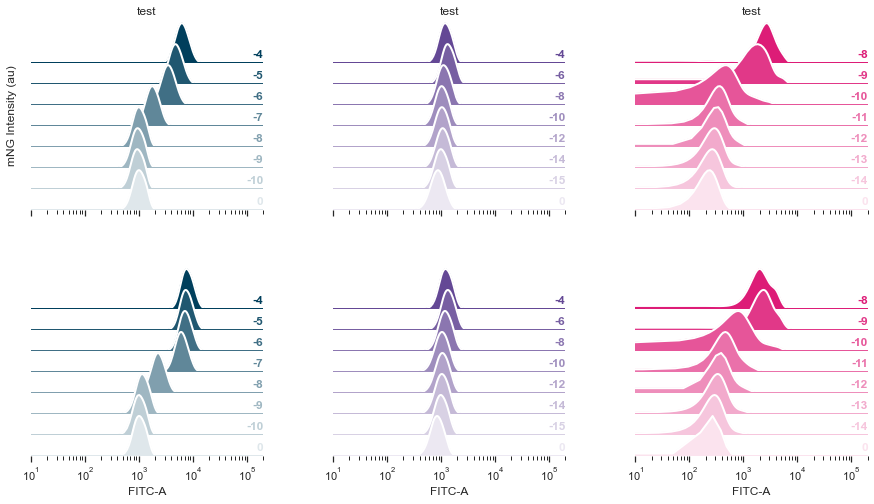

In [17]:
fig = plt.figure(figsize=(15,8))
widths = [1,1,1]
heights = [1,1]
gs0 = gridspec.GridSpec(2, 3, figure=fig,wspace=.3,hspace=.3,width_ratios=widths,
                          height_ratios=heights)
sns.set_context('notebook')
sns.set_style('white')
spines = ["top","right","left","bottom"]
# Initialize plot axes
axes = gs0.subplots()
#ridge_plot(Data,'LuxR',5,grid=gs0[0,0])
for i,(iptg,lab) in enumerate(zip([0,10],[False,True])):
# ridge plots
    ridge_plot(Data,'LuxR',iptg,grid=gs0[i,0],xlabel=lab,xticklabels=lab)
    ridge_plot(Data,'TraR',iptg,grid=gs0[i,1],xlabel=lab,xticklabels=lab)
    ridge_plot(Data,'LasR',iptg,grid=gs0[i,2],xlabel=lab,xticklabels=lab)
for ax in axes.ravel():
    #ax.axis('off')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    #ax.set_xticklabels([])
    for s in spines:
        ax.spines[s].set_visible(False)
    ax.get_xaxis().set_visible(False)
for ax in axes[0]:
    ax.set_xlabel('')
    ax.set_title('test')
    ax.xaxis.set_major_formatter(plt.NullFormatter())
    ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)
axes[0,0].set_ylabel('mNG Intensity (au)')

C:\Users\sakkosjo\AppData\Local\Temp/ipykernel_30360/4172148379.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fit = fits[(fits.IPTG==iptg) & (fits.Family==Family)].mean()
C:\Users\sakkosjo\AppData\Local\Temp/ipykernel_30360/4172148379.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fit = fits[(fits.IPTG==iptg) & (fits.Family==Family)].mean()
C:\Users\sakkosjo\AppData\Local\Temp/ipykernel_30360/4172148379.py:34: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  fit = fits[(fits.

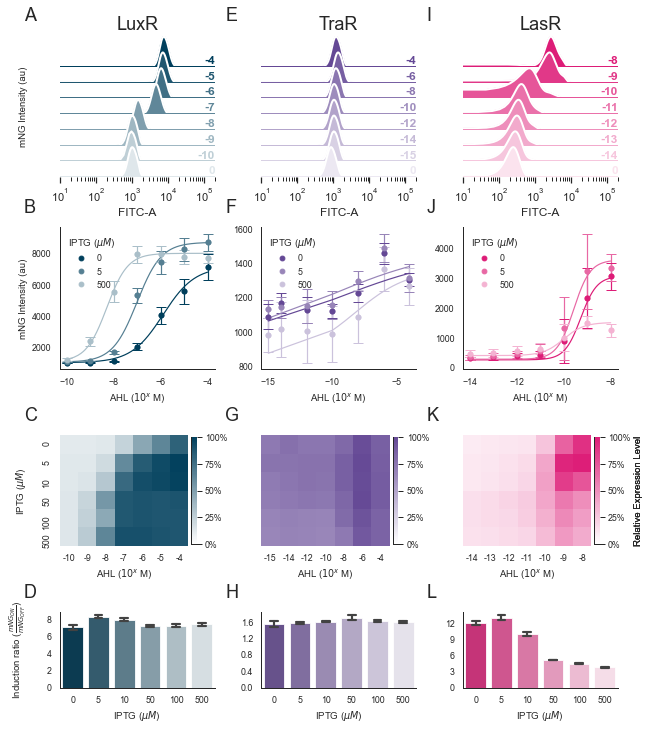

In [18]:
fig = plt.figure(figsize=(10,12))
widths = [1,1,1]
heights = [.75, .75, .75,.4]
gs0 = gridspec.GridSpec(4, 3, figure=fig,wspace=.3,hspace=.4,width_ratios=widths,
                          height_ratios=heights)
sns.set_context('paper')
sns.set_style('white')
spines = ["top","right","left","bottom"]

# Initialize plot axes
axes = gs0.subplots()

# Diagrams

""" axs = axes.ravel()
families = ['LuxR','LasR','TraR']
for i,family in enumerate(families):
    img = io.imread(f'QS Families_{family}.png')
    axs[i].imshow(img)
    axs[i].axis('off') """

# # Hill plots
plot_hill(mfi,[0,5,500],'LuxR',fits,Lux_cmap,ax=axes[1, 0])
plot_hill(mfi,[0,5,500],'TraR',fits,Tra_cmap,ax=axes[1, 1])
plot_hill(mfi,[0,5,500],'LasR',fits,Las_cmap,ax=axes[1, 2])

# # Heatmaps
sns.set_style('white')
make_heatmap(mfi,'LuxR',axes[2, 0],cmap=Lux_cmap_r,cbar_kws=dict(pad=0.02,shrink=.75))
make_heatmap(mfi,'TraR',axes[2, 1],cmap= Tra_cmap_r,cbar_kws=dict(pad=0.02,shrink=.75))
make_heatmap(mfi,'LasR',axes[2, 2],cmap=Las_cmap_r,cbar_kws=dict(pad=0.02,shrink=.75))
# # Hill Params
plot_ratio(mfi,'LuxR',colormap=Lux_cmap,ax=axes[3, 0])
plot_ratio(mfi,'TraR',colormap=Tra_cmap,ax=axes[3, 1])
plot_ratio(mfi,'LasR',colormap=Las_cmap,ax=axes[3, 2])
# ridge plots
ridge_plot(Data,'LuxR',5,grid=gs0[0,0])
ridge_plot(Data,'TraR',5,grid=gs0[0,1])
ridge_plot(Data,'LasR',5,grid=gs0[0,2])




for ax in axes[0]:
    #ax.axis('off')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    #ax.set_xticklabels([])
    ax.get_xaxis().set_visible(False)
    for s in spines:
        ax.spines[s].set_visible(False)
for ax in axes[2]:
    for s in spines:
        ax.spines[s].set_visible(False)
#for ax in axes[3]:
    #ax.axis('off')
fig.align_ylabels()
#fig.tight_layout()
axes[0,0].set_title('LuxR',fontsize=18)
axes[0,1].set_title('TraR',fontsize=18)
axes[0,2].set_title('LasR',fontsize=18)
axes[2,1].get_yaxis().set_visible(False)
axes[2,2].get_yaxis().set_visible(False)
axes[3,0].yaxis.set_major_locator(MaxNLocator(5))
axes[3,1].yaxis.set_major_locator(MaxNLocator(5))
axes[3,2].yaxis.set_major_locator(MaxNLocator(5))
#lux
label_panel(axes[0,0],'A')
label_panel(axes[1,0],'B')
label_panel(axes[2,0],'C')
label_panel(axes[3,0],'D')

#tra
label_panel(axes[0,1],'E')
label_panel(axes[1,1],'F')
label_panel(axes[2,1],'G')
label_panel(axes[3,1],'H')
#las
label_panel(axes[0,2],'I')
label_panel(axes[1,2],'J')
label_panel(axes[2,2],'K')
label_panel(axes[3,2],'L')
for ax in axes[:,1:].ravel():
    ax.set_ylabel('')

axes[0,0].set_ylabel('mNG Intensity (au)')
fig.savefig('../Figures/SE Characterization.pdf',bbox_inches='tight')

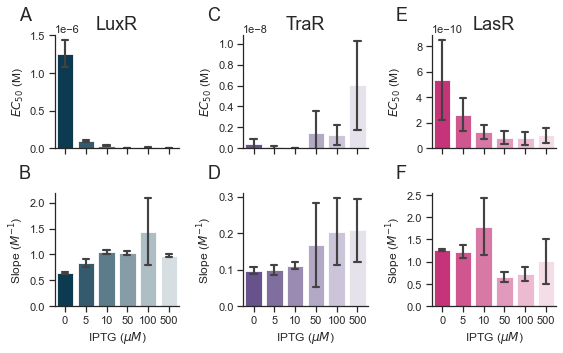

In [19]:
# Figure S1
def plot_hill_params(mfi,Family,fits,axes,**kwargs):

    #gs1 = grid.subgridspec(2, 1)
    #axes=gs1.subplots()
    median_fluorescence = mfi[mfi.Family==Family]
    fit = fits[fits.Family==Family]
    n = len(median_fluorescence.IPTG.unique())
    colors = AHL_cols(Family,n)
    sns.barplot(x='IPTG',y='EC50',data=fit,ax=axes[0],ci='sd',palette=colors,capsize=.3)
    #axes[1].set_yscale('log')
    axes[0].set_ylabel(r'$EC_{50}$ (M)')
    sns.barplot(x='IPTG',y='Slope',data=fit,ax=axes[1],ci='sd',palette=colors,capsize=.3)
    #axes[2].set_yscale('log')

    axes[0].set_xlabel('')
    axes[0].set_xticklabels([])
    axes[1].set_xlabel(r'IPTG ($\mu M$)')
    axes[1].set_ylabel(r'Slope ($M^{-1}$)')
    sns.despine()
    axes[0].set_ylim(bottom=0)
    return 
#EC50/Slope
#fig = plt.figure(figsize=(10,10))
fig, axes = plt.subplots(nrows=2,ncols=3,figsize=(8,5))
#gs0 = gridspec.GridSpec(1, 3, figure=fig,wspace=.3,hspace=.3,)
sns.set_context('paper')
sns.set_style('white')
spines = ["top","right","left","bottom"]
# Initialize plot axes
#axes = gs0.subplots()
plot_hill_params(mfi,'LuxR',fits,colormap=Lux_cmap,axes=axes[:,0])
plot_hill_params(mfi,'TraR',fits,colormap=Tra_cmap,axes=axes[:,1])
plot_hill_params(mfi,'LasR',fits,colormap=Las_cmap,axes=axes[:,2])

fig.align_ylabels()
#fig.tight_layout()
axes[0,0].set_title('LuxR',fontsize=18)
axes[0,1].set_title('TraR',fontsize=18)
axes[0,2].set_title('LasR',fontsize=18)

#lux
label_panel(axes[0,0],'A')
label_panel(axes[1,0],'B')


#tra
label_panel(axes[0,1],'C')
label_panel(axes[1,1],'D')

#las
label_panel(axes[0,2],'E')
label_panel(axes[1,2],'F')

#axes[0,1].set_ylim(bottom=0)
fig.tight_layout()
fig.savefig('../Figures/Hill parameters.png',bbox_inches='tight',dpi=600)

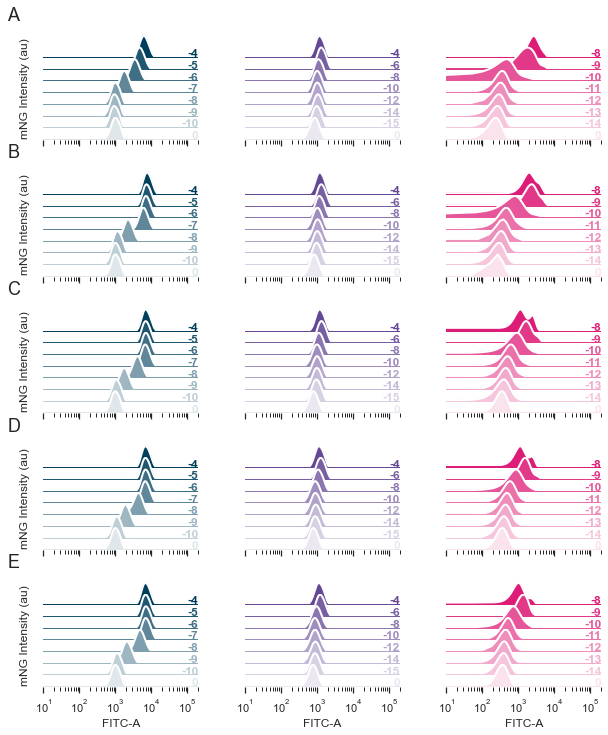

In [20]:
iptgs = Data.loc[(Data.Family =='LuxR') & (Data.IPTG !=5)].IPTG.unique()
ahls = Data.loc[Data.Family=='LuxR'].AHL.unique()
fig = plt.figure(figsize=(10,12))

gs0 = gridspec.GridSpec(len(iptgs), 3, figure=fig,wspace=.3,hspace=.3)
sns.set_context('notebook')
sns.set_style('white')
spines = ["top","right","left","bottom"]
# Initialize plot axes
axes = gs0.subplots()
#ridge_plot(Data,'LuxR',5,grid=gs0[0,0])
for i,iptg in enumerate(iptgs):
    if i == len(iptgs)-1:
        lab = True
    else:
        lab = False
# ridge plots
    ridge_plot(Data,'LuxR',iptg,grid=gs0[i,0],xlabel=lab,xticklabels=lab)
    ridge_plot(Data,'TraR',iptg,grid=gs0[i,1],xlabel=lab,xticklabels=lab)
    ridge_plot(Data,'LasR',iptg,grid=gs0[i,2],xlabel=lab,xticklabels=lab)
for ax in axes.ravel():
    #ax.axis('off')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_yticklabels([])
    #ax.set_xticklabels([])
    for s in spines:
        ax.spines[s].set_visible(False)
    ax.get_xaxis().set_visible(False)
for ax in axes[:,0]:
    ax.set_ylabel('mNG Intensity (au)')
# sns.set_context('paper')

# sns.set_style('white')
# spines = ["top","right","left","bottom"]
# Initialize plot axes
#axes = gs0.subplots()

# for i,iptg in enumerate(iptgs):
# # ridge plots
#     ridge_plot(Data,'LuxR',iptg,grid=gs0[i,0])
#     ridge_plot(Data,'TraR',iptg,grid=gs0[i,1])
#     ridge_plot(Data,'LasR',iptg,grid=gs0[i,2])
#     axes[i,0].set_ylabel(f'IPTG={i} $\mu M$')

# for ax in axes.ravel():
#     #ax.axis('off')
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_yticklabels([])
#     #ax.set_xticklabels([])
#     ax.get_xaxis().set_visible(False)
#     for s in spines:
#         ax.spines[s].set_visible(False)
# for ax in axes[0]:
#     #ax.axis('off')
#     ax.set_ylabel('')
#     ax.set_xlabel('')
#     ax.set_yticklabels([])
#     ax.set_xticklabels([])
#     ax.get_xaxis().set_visible(False)
#     for s in spines:
#         ax.spines[s].set_visible(False)
# axes[0,0].set_title('LuxR',fontsize=18)
# axes[0,1].set_title('TraR',fontsize=18)
# axes[0,2].set_title('LasR',fontsize=18)
#sns.despine()
for ax in axes.ravel()[:-3]:
    ax.set_xlabel('')
    ax.xaxis.set_major_formatter(plt.NullFormatter())

label_panel(axes[0,0],'A')
label_panel(axes[1,0],'B')
label_panel(axes[2,0],'C')
label_panel(axes[3,0],'D')
label_panel(axes[4,0],'E')

fig.savefig('../Figures/population-level iptg-ahl-fitc-a.pdf',bbox_inches='tight')

In [21]:
mfi[mfi.Family=='LuxR'].groupby(['IPTG','AHL']).mean().reset_index()

,IPTG,AHL,logAHL,Replicate,FITC-A,R
0,0,0.000000e+00,0.0,2.0,1095.279956,7.012148
1,0,1.000000e-10,-10.0,2.0,1022.823331,7.012148
2,0,1.000000e-09,-9.0,2.0,1031.309985,7.012148
3,0,1.000000e-08,-8.0,2.0,1102.396655,7.012148
4,0,1.000000e-07,-7.0,2.0,2048.489916,7.012148
5,0,1.000000e-06,-6.0,2.0,4053.053312,7.012148
6,0,1.000000e-05,-5.0,2.0,5575.783292,7.012148
7,0,1.000000e-04,-4.0,2.0,7154.243090,7.012148
8,5,0.000000e+00,0.0,2.0,1119.403328,8.253445
9,5,1.000000e-10,-10.0,2.0,1056.113330,8.253445
